# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки:**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**

- Price — цена (евро)

## Подготовка данных

Импортируем необходимые библиотеки

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

Загрузим датафрейм

In [2]:
pth = '/datasets/autos.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth)
else:
    print('Something is wrong')

Выведем первые 5 строчек датафрейма и посмотрим общую информацию о нем

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Переменуем названия столбцов в соответствии со змеином стилем для удобства работы со столбцами  

In [5]:
data = data.rename(str.lower, axis='columns').rename(columns={
    'datecrawled':'date_crawled',
    'vehicletype':'vehicle_type',
    'registrationyear':'registration_year',
    'registrationmonth':'registration_month',
    'fueltype':'fuel_type',
    'datecreated':'date_created',
    'numberofpictures':'number_of_pictures',
    'postalcode':'postal_code',
    'lastseen':'last_seen'
})

Уберем столбцы с неинформативными признаками

In [6]:
data = data.drop(['date_crawled', 'registration_month', 'date_created','postal_code','last_seen'], axis=1)

Были убраны такие столбцы как: 

- date_crawled — дата скачивания анкеты из базы
- registration_month — месяц регистрации автомобиля
- date_created — дата создания анкеты
- postal_code — почтовый индекс владельца анкеты (пользователя)
- last_seen — дата последней активности пользователя

Посмотрим какое количество пропусков содержит наш датафрейм

In [7]:
data.isna().sum()

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
fuel_type             32895
brand                     0
repaired              71154
number_of_pictures        0
dtype: int64

Все столбцы, которые в которых обнаружены пропуски, содержат категориальные признаки. Чтобы не удалять такое количество данных, заменим все пропуски на значение 'unknow'

In [8]:
data = data.fillna('unknow')

Найдем неявные дубликаты в колонках с категориальными данными

In [9]:
data['vehicle_type'].unique()

array(['unknow', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Неявные дубликаты не обнаружены

In [10]:
data['gearbox'].unique()

array(['manual', 'auto', 'unknow'], dtype=object)

Неявные дубликаты не обнаружены

In [11]:
sorted(data['model'].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Обнаружен 1 неявные дубликат со значением rangerover и range_rover. Заменим значение rangerover на range_rover

In [12]:
data['model'] = data['model'].replace('rangerover', 'range_rover')

In [13]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', 'unknow', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Неявные дубликаты не обнаружены

In [14]:
sorted(data['brand'].unique())

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

Неявные дубликаты не обнаружены

Найдем явные дубликаты

In [15]:
data['brand'] = data['brand'].str.lower()
data['model'] = data['model'].str.lower()

In [16]:
data.duplicated().sum()

45040

Найдено большое количество дубликатов. Поскольку объявления могут повторяться для одного и того же автомобиля, а также автомобили могут дублироваться, мы можем удалить дубликаты

Запишем в переменную количество строчек, для того чтобы знать процент удаленных данных

In [17]:
data_original_count = data.shape[0]
data_original_count

354369

In [18]:
data = data.drop_duplicates().reset_index(drop=True)

Найдем выбросы для количественных признаков

Найдем выбросы в столбце registration_year

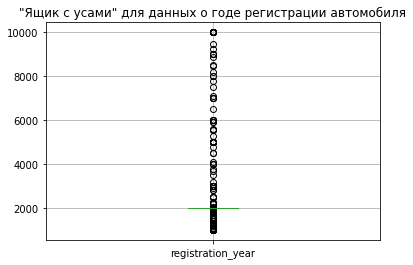

In [19]:
data.boxplot(column='registration_year')
plt.title('"Ящик с усами" для данных о годe регистрации автомобиля');

In [20]:
sorted(data['registration_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

Найдено большое количество выбросов и нереальных данных. Сделаем срезку для года регистрации с 1985 по 2020 год

In [21]:
max_year = 2020
min_year = 1985

data = data.query('registration_year < @max_year and registration_year >= @min_year')

Посмотрим что стало с boxplot'ом

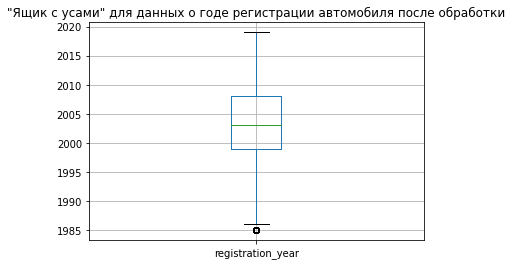

In [22]:
data.boxplot(column='registration_year')
plt.title('"Ящик с усами" для данных о годe регистрации автомобиля после обработки');

Найдем выбросы в столбце power

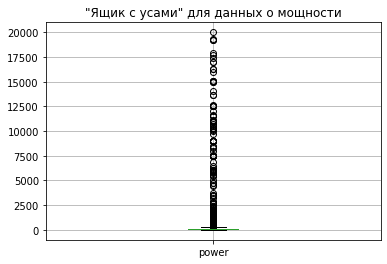

In [23]:
data.boxplot(column='power')
plt.title('"Ящик с усами" для данных о мощности');

Найдено большое количество выбросов и нереальных данных. Сделаем срезку для мощности с 10 до 300 л.с.

In [24]:
min_power = 10
max_power = 300

data = data.query('power > @min_power and power < @max_power')

Посмотрим что стало с boxplot'ом

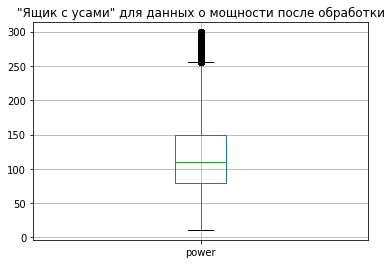

In [25]:
data.boxplot(column='power')
plt.title('"Ящик с усами" для данных о мощности после обработки');

Найдем выбросы в столбце kilometer

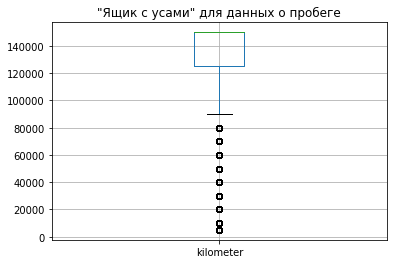

In [26]:
data.boxplot(column='kilometer')
plt.title('"Ящик с усами" для данных о пробеге');

Тут выбросов не обнаружено

Найдем выбросы в столбце price

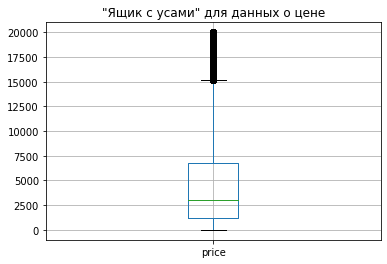

In [27]:
data.boxplot(column='price')
plt.title('"Ящик с усами" для данных о цене');

Выбросы не обнаружены, но есть сомнительные значения. Сделаем срезку для цены выше 500 евро

In [28]:
min_price = 500

data = data.query('price > @min_price')

Посмотрим что стало с boxplot'ом

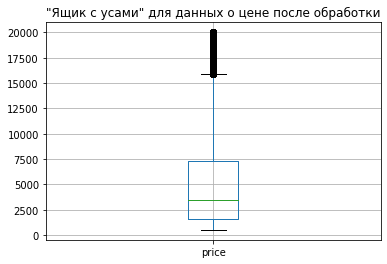

In [29]:
data.boxplot(column='price')
plt.title('"Ящик с усами" для данных о цене после обработки');

Посмотрим какое количество значений мы потеряли в процессе предобработки

In [30]:
(1 - data.shape[0] / data_original_count) * 100

32.00562125919593

Потеряно 32% сторчек от первичного датафрейма. Хоть это и очень много, но все уданные значения составляют дубликаты и выбросы с нереальными данными. Такие данные только помешают обучению модели

In [31]:
data = data.reset_index(drop=True)

Разделим датафрейм на выбоки с целевыми и таргетными принаками

In [79]:
features = data.drop('price', axis=1)
target = data['price']

Разделим выборки с целевыми и таргетными признаками на обучающую, валидационную и тестовую выборку

In [80]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

In [81]:
print('Обучающуя выборка:', features_train.shape[0], target_train.shape[0])
print('Валидационнуя выборка:', features_valid.shape[0], target_valid.shape[0])
print('Тестовая выборка:', features_test.shape[0], target_test.shape[0])

Обучающуя выборка: 144570 144570
Валидационнуя выборка: 48191 48191
Тестовая выборка: 48190 48190


Закодируем категориальные признаки методом Ordinal Encoding

In [82]:
pd.options.mode.chained_assignment = None

columns_list = ['vehicle_type','gearbox', 'model', 'fuel_type', 'brand', 'repaired']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train[columns_list])

features_train[columns_list] = encoder.transform(features_train[columns_list])
features_valid[columns_list] = encoder.transform(features_valid[columns_list])
features_test[columns_list] = encoder.transform(features_test[columns_list])

Промасштабируем количественные целевые признаки

In [83]:


standart_columns = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train[standart_columns])
features_train[standart_columns] = scaler.transform(features_train[standart_columns])
features_valid[standart_columns] = scaler.transform(features_valid[standart_columns])
features_test[standart_columns] = scaler.transform(features_test[standart_columns])

**Вывод:** В данном разделе осуществлена предобработка данных: Переименованы названия столбцов в соответствии со змеином стилем, удалены явные и неявные дубликаты, удалены выбросы и сомнительные данные. Обработаны пропуски: поскольку все пропуски находились в колонках с категориальными данными, пропуски заменены на значение ‘unknow’. Также для категориальных признаков была применена техника кодирования Ordinal Encoding, а для количественных признаков было произведено масштабирование данных.  

## Обучение моделей

Напишем функцию для определения метрики RMSE

In [37]:
def rmse_func(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

Обучим модель линейной регрессии

In [38]:
linear_model = LinearRegression()

In [39]:
%%time

linear_model.fit(features_train, target_train)
print('Время обучения модели:')

Время обучения модели:
CPU times: user 35.4 ms, sys: 16.5 ms, total: 51.9 ms
Wall time: 42.1 ms


In [40]:
%%time

linear_predict = linear_model.predict(features_valid)
print('Время предсказания модели:')

Время предсказания модели:
CPU times: user 5.61 ms, sys: 7.71 ms, total: 13.3 ms
Wall time: 4.95 ms


In [41]:
linear_rmse = rmse_func(target_valid, linear_predict)
print(f'RMSE модели линейной регрессии {linear_rmse:.2f}')

RMSE модели линейной регрессии 2834.87


In [59]:
linear_list = ['Линейная регрессия', 2834.87, 42.1, 4.95]

**Итоговые значения для модели линейной регрессии:**

- RMSE - 2834.87 EURO
- время обучения модели - 42.1 ms
- время предсказания модели - 4.95 ms

Подберем гиперпараметры для модели дерева решений и обучим наилучшую модель

In [43]:
rmse_score = 5000

for depth in range(1,15):
    tree_model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    tree_model.fit(features_train, target_train)
    tree_predict = tree_model.predict(features_valid)
    tree_rmse = rmse_func(target_valid, tree_predict)
    if tree_rmse < rmse_score:
        rmse_score = tree_rmse
        best_depth = depth
        best_tree_model = tree_model
        
print(f'RMSE модели дерева решений {rmse_score:.2f}, глубина дерева: {best_depth}')

RMSE модели дерева решений 1892.89, глубина дерева: 14


In [44]:
%%time

best_tree_model.fit(features_train, target_train)

CPU times: user 341 ms, sys: 7.23 ms, total: 348 ms
Wall time: 353 ms


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [45]:
%%time

tree_predict = best_tree_model.predict(features_valid)

CPU times: user 16.5 ms, sys: 41 µs, total: 16.5 ms
Wall time: 15.2 ms


In [60]:
tree_list = ['Дерево решений', 1892.89, 353, 15.2]

**Итоговые значения для модели дерева решений:**

- RMSE - 1892.89 EURO
- время обучения модели - 353 ms
- время предсказания модели - 15.2 ms

Подберем гиперпараметры для модели случайного леса и обучим наилучшую модель

In [47]:
rmse_score = 5000

for depth in range(2,15):
    for est in range(5, 101, 5):
        forest_model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=est)
        forest_model.fit(features_train, target_train)
        forest_predict = forest_model.predict(features_valid)
        forest_rmse = rmse_func(target_valid, forest_predict)
        if forest_rmse < rmse_score:
            rmse_score = forest_rmse
            best_depth = depth
            best_est = est
            best_forest_model = forest_model
        
print(f'RMSE модели дерева решений {rmse_score:.2f}, глубина дерева: {best_depth}, количество деревьев: {est}')

RMSE модели дерева решений 1662.29, глубина дерева: 14, количество деревьев: 100


In [48]:
%%time

best_forest_model.fit(features_train, target_train)

CPU times: user 25 s, sys: 75.4 ms, total: 25.1 s
Wall time: 25.1 s


RandomForestRegressor(max_depth=14, random_state=12345)

In [49]:
%%time

forest_predict = best_forest_model.predict(features_valid)

CPU times: user 842 ms, sys: 4.04 ms, total: 847 ms
Wall time: 853 ms


In [61]:
forest_list = ['Случайный лес', 1662.29, 25.1*1000, 853]

**Итоговые значения для модели дерева решений:**

- RMSE - 1662.29 EURO
- время обучения модели - 25.2 s
- время предсказания модели - 821 ms

Подберем гиперпараметры для модели градиентного бустинга и обучим наилучшую модель

In [53]:
for est in range(2000, 2001):
    for depth in range(0,1):
        LGBM_model = LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        LGBM_model.fit(features_train, target_train)
        LGBM_predict = LGBM_model.predict(features_valid)
        LGBM_rmse = rmse_func(target_valid, LGBM_predict)
        if LGBM_rmse < rmse_score:
            rmse_score = LGBM_rmse
            LGBM_est = est
            LGBM_depth = depth
            best_LGBM_model = LGBM_model

print(f'RMSE модели градиентного бустинга {rmse_score:.2f}, глубина дерева: {LGBM_depth}, количество деревьев: {LGBM_est}')

RMSE модели градиентного бустинга 1525.74, глубина дерева: 0, количество деревьев: 2000


In [54]:
%%time

best_LGBM_model.fit(features_train, target_train)

CPU times: user 2h 5min 28s, sys: 1min 7s, total: 2h 6min 35s
Wall time: 2h 7min 17s


LGBMRegressor(max_depth=0, n_estimators=2000, random_state=12345)

In [55]:
%%time

LGBM_predict = best_LGBM_model.predict(features_valid)

CPU times: user 10.3 s, sys: 178 µs, total: 10.3 s
Wall time: 10.5 s


In [62]:
LGBM_list = ['Градиентный бустинг', 1525.74, 51.6*1000*60*60, 11*1000]

**Итоговые значения для модели градиентного бустинга:**

- RMSE - 1525.92 EURO
- время обучения модели - 2h 7min 17s
- время предсказания модели - 10.5 s

Соберем полученные данные в один датафрейм

In [64]:
data_model = pd.DataFrame(
    [linear_list, tree_list, forest_list, LGBM_list], columns=['model', 'rmse', 'time_fit', 'time_predict']
)

In [65]:
data_model

,model,rmse,time_fit,time_predict
0,Линейная регрессия,2834.87,42.1,4.95
1,Дерево решений,1892.89,353.0,15.20
2,Случайный лес,1662.29,25100.0,853.00
3,Градиентный бустинг,1525.74,185760000.0,11000.00


**Вывод:** В данном разделе были обучены 4 различные модели: Линейная регрессия, дерево решений, случайный лес и градиентный бустинг. Градиентный бустинг показал лучший результат метрики RMSE, хоть по времени и уступает другим моделям. Лучшее время обучения и предсказания показала модель линейной регрессии, но по метрике RMSE регрессия показала худший результат.

## Анализ моделей

Посмотрим еще раз на сводную таблицу с параметрами моделей

In [66]:
data_model

,model,rmse,time_fit,time_predict
0,Линейная регрессия,2834.87,42.1,4.95
1,Дерево решений,1892.89,353.0,15.20
2,Случайный лес,1662.29,25100.0,853.00
3,Градиентный бустинг,1525.74,185760000.0,11000.00


Для заказчика важны такие параметры как: 

- качество предсказания
- время обучения модели
- время предсказания модели 

Лучший результат метрики RMSE показала модель градиентного бустинга, но время на обучение и предсказание затрачивается больше чем у других моделей. Порог RMSE – 2500 EURO. Для финального тестирования возьмем модель, которая проходит этот порог и имеет меньшее время обучения и предсказания. По таблице видно, что такая модель – Дерево решений. 

Для финального обучения и тестирования объединим обучающую и валидационную выборку 

In [84]:
features_train = pd.concat([features_train] + [features_valid])
target_train = pd.concat([target_train] + [target_valid])

Обучим и протестируем лучшую модель дерева решений

In [85]:
%%time

best_tree_model.fit(features_train, target_train)

CPU times: user 463 ms, sys: 0 ns, total: 463 ms
Wall time: 461 ms


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [86]:
%%time

test_predict = best_tree_model.predict(features_test)

CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 13.3 ms


In [87]:
test_rmse = rmse_func(target_test, test_predict)
test_rmse

1849.7212074639476

**Итоговые значения для финального тестирования дерева решений:**

- RMSE - 1849.72 EURO
- время обучения модели - 461 ms
- время предсказания модели - 13.3 ms

Сравним нашу выбранную модель с дамми-моделью для проверки адекватности предсказаний

In [88]:
dummy_regr = DummyRegressor()
dummy_regr.fit(features_train, target_train)
dummy_regr_predict = dummy_regr.predict(features_test)
dummy_regr_rmse= rmse_func(target_test, dummy_regr_predict)
print(f'Параметр RMSE dummy-модели: {dummy_regr_rmse}')

Параметр RMSE dummy-модели: 4516.728544773274


In [89]:
if dummy_regr_rmse-test_rmse > 0:
    print(f'Разница предсказаний дерева решений и dummy-модели: {dummy_regr_rmse - test_rmse:.2f} EURO. Проверка пройдена')
else:
    print(f'Разница предсказаний дерева решений и dummy-модели: {dummy_regr_rmse - test_rmse:.2f} EURO. Проверка не пройдена')

Разница предсказаний дерева решений и dummy-модели: 2667.01 EURO. Проверка пройдена


**Вывод:** Благодаря полученным данным из предыдущего пункта на финальное тестирование была отправлена модель дерева решений, так как она удовлетворяет условию метрики RMSE и имеет меньшее время обучения и предсказания. Модель дерева решений была сопоставлена дамми-модели и показала результат лучше, чем дамми-модель, что говорит о том что, модель дерева проходит тестирование на адекватность предсказаний и ее можно использовать для дальнейшего предсказания цены. 

## Итоговый вывод

В разделе ‘Подготовка данных ’ было сделано следующие: 

- Пропуски в колонках с категориальными признаками были заменены на ‘unknow’
- Найдены и исправлены неявные дубликаты 
- Удалены явные дубликаты
- Удалены выбросы и спорные значения
- Закодировали категориальные признаки методом Ordinal Encoding
- Разбили датасет на обучающую, валидационную и тестовую выборки
- Промасштабировали количественные признаки

По итогу было потеряно 32% всех данных. Это большое значение, но удаленные значения составляют только дубликаты и выбросы, такие значения только отрицательно повлияли бы на обучение моделей. 

В разделе ‘Обучение моделей’ мы обучили 4 модели: модель линейной регрессии, модель дерева решений, модель случайного леса и модель градиентного бустинга. По значению метрики RMSE лучше всего себя показала модель градиентного бустинга, но по значениям времени предсказания и обучение данная модель показала худший результат. Лучшее время показала модель линейной регрессии, однако значение RMSE метрики превышает допустимый порог. Все полученные значения RMSE метрики и время обучения и предсказания были занесены в сводную  таблицу, для дальнейшего определения модели, которая отправится на финальное тестирование. 

В разделе ‘Анализ моделей’ была выбрана лучшая модель для финального тестирования – модель дерева решений. Модель дерева решений удовлетворяет условия прохождения по RMSE метрики и имеет наименьше время обучения и предсказания, что очень важно для заказчика. Для финального тестирования были объединены обучающая и валидационная выборка. На тестирование модель дерева показала результат лучше, чем на валидации. Финальные результаты следущие: 

- RMSE - 1849.72 EURO
- время обучения модели - 461 ms
- время предсказания модели - 13.3 ms

Финальная модель сравнили с дамми-моделью для тестирования на адекватность полученных предсказаний. Финальная модель лучше предсказывает по RMSE метрики на 2665.39 EURO. Проверка на адекватность была успешно пройдена. 
